<a href="https://colab.research.google.com/github/nasy-sr/Project-Tugas-Kelompok-Neural-Networks/blob/notebooks/Dataset_2_%E2%80%93_Heart_Failure_Clinical_Records.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setup
import numpy as np
import pandas as pd

from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import matplotlib.pyplot as plt

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
# Mount Google Drive & Load dataset
drive.mount("/content/drive")

file_path = "/content/drive/MyDrive/Tugas_Kelompok_Machine_Learning/Data_Set/heart_failure_clinical_records_dataset.csv"
df = pd.read_csv(file_path)

print("Loaded:", file_path)
display(df.head())
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded: /content/drive/MyDrive/Tugas_Kelompok_Machine_Learning/Data_Set/heart_failure_clinical_records_dataset.csv


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Shape: (299, 13)

Columns: ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT']

Dtypes:
 age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object


In [ ]:
# Target & cleaning ringan
TARGET = "DEATH_EVENT"
drop_cols = []

df = df.drop(columns=drop_cols, errors="ignore")
df = df.dropna(subset=[TARGET])

X = df.drop(columns=[TARGET])
y = df[TARGET]

y = y.astype(int)

print("\nDistribusi target (DEATH_EVENT):")
print(y.value_counts())


Distribusi target (DEATH_EVENT):
DEATH_EVENT
0    203
1     96
Name: count, dtype: int64


In [ ]:
# Identifikasi fitur numerik vs kategorikal
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("\nNumerik:", num_cols)
print("Kategorikal:", cat_cols)


Numerik: ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']
Kategorikal: []


In [ ]:
# Preprocess (impute + scaling)
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)


In [ ]:
# Split 70:30 (klasifikasi => stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=SEED,
    stratify=y
)

X_train_p = preprocess.fit_transform(X_train)
X_test_p  = preprocess.transform(X_test)

n_features = X_train_p.shape[1]
print("\nn_features:", n_features)


n_features: 12


In [ ]:
# Build model (Binary Classification)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_features,)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]

history = model.fit(
    X_train_p, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.5297 - auc: 0.5019 - loss: 0.6900 - val_accuracy: 0.6429 - val_auc: 0.4985 - val_loss: 0.6641
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6627 - auc: 0.6470 - loss: 0.6381 - val_accuracy: 0.7381 - val_auc: 0.6158 - val_loss: 0.6254
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6691 - auc: 0.6571 - loss: 0.6207 - val_accuracy: 0.7381 - val_auc: 0.6950 - val_loss: 0.5951
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6947 - auc: 0.7265 - loss: 0.5921 - val_accuracy: 0.6905 - val_auc: 0.7390 - val_loss: 0.5691
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7055 - auc: 0.8008 - loss: 0.5666 - val_accuracy: 0.7143 - val_auc: 0.7859 - val_loss: 0.5463
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7212 - auc: 0.8467 - loss: 0.5376 - val_accuracy: 0.7381 - val_auc: 0.8123 - val_loss: 0.5266
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accura

In [ ]:
# Evaluasi
y_prob = model.predict(X_test_p).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Confusion Matrix:
[[53  8]
 [13 16]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8030    0.8689    0.8346        61
           1     0.6667    0.5517    0.6038        29

    accuracy                         0.7667        90
   macro avg     0.7348    0.7103    0.7192        90
weighted avg     0.7591    0.7667    0.7603        90



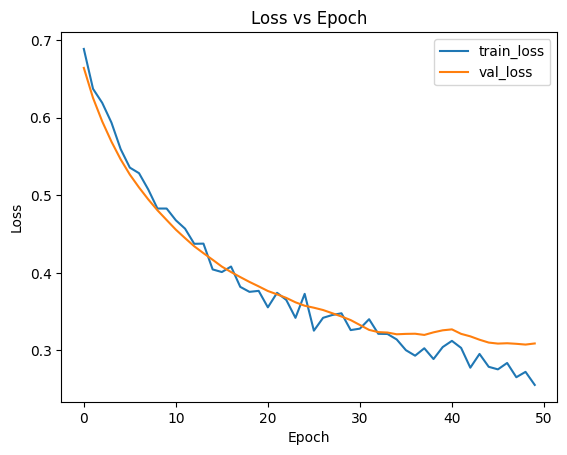

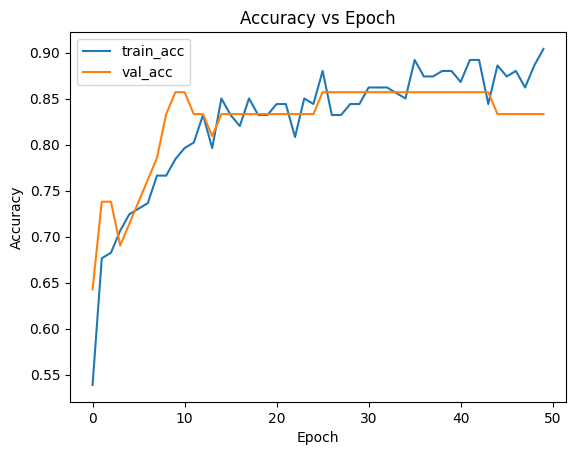

In [ ]:
# Plot training curve (loss & accuracy)
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()